## Testing MCMC

MCMCM test

In [16]:
using Turing, Distributions
using Optim
using DataFrames
using Plots, StatsPlots
using StatsBase, Random

# # Disable Turing's progress meter for this tutorial.
# Turing.

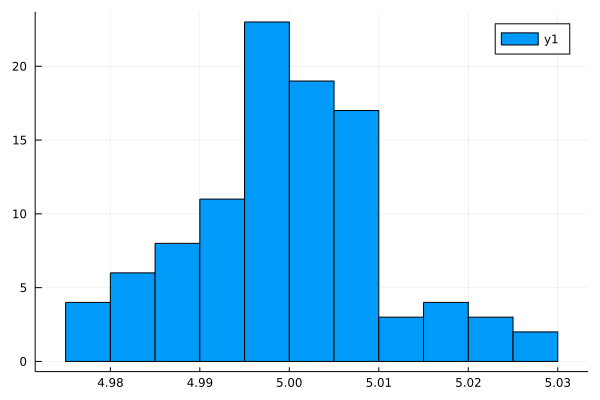

In [84]:
data = rand(Normal(5, 0.01), 100)
plot(data, seriestype=:histogram)

In [85]:
@model function inference(x)
    μ = 5
    σ ~ InverseGamma(2, 3)
    for i in eachindex(x)
        x[i] ~ Normal(μ, σ)
    end
end

# mle_est = optimize(inference(data), MLE(), NelderMead())
# chain = sample(inference(data), SMC(), 10000)
# chain = sample(inference(data), PG(10), 1000)
chain = sample(inference(data), HMC(0.1, 5), 10000)
# chain = sample(inference(data), HMCDA(0.15, 0.65), 10000)
# chain = sample(inference(data), NUTS(0.65), 10000)
# chains = mapreduce(c -> sample(inference(data), NUTS(.65), 1000), chainscat, 1:3)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04


Chains MCMC chain (10000×10×1 Array{Float64, 3}):

Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = σ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, n_steps, nom_step_size, step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat 
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64 

           σ    0.0334    0.0069     0.0001    0.0003   596.5843    1.0007

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           σ    0.0276    0.0309    0.0330    0.0352    0.0401


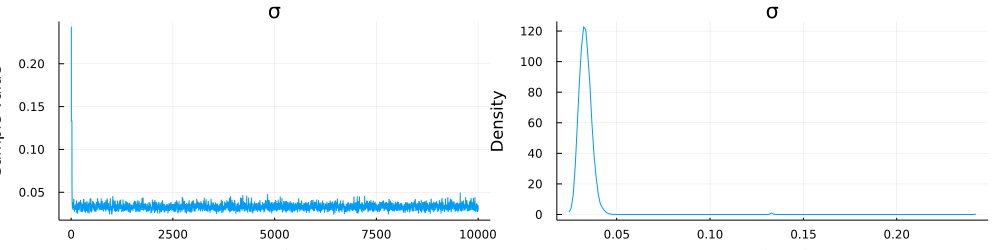

In [86]:
plot(chain)

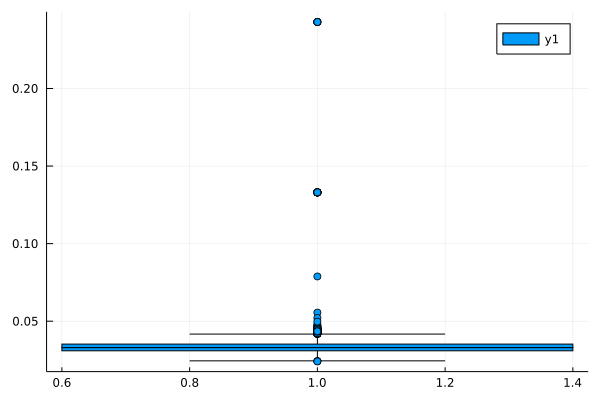

In [87]:
boxplot(chain[:σ])

In [70]:
myfun(x) = 0.1x^2 + 1.0 
xdata = [range(0., 4.0, length=30);]
ydata = myfun.(xdata) + 0.1xdata.*randn(size(xdata)) 

mymodel(x, a, b) = a*x^2 + b

mymodel (generic function with 1 method)

Plain data fitting

How to obtain confidence intervals from optim? IDK.

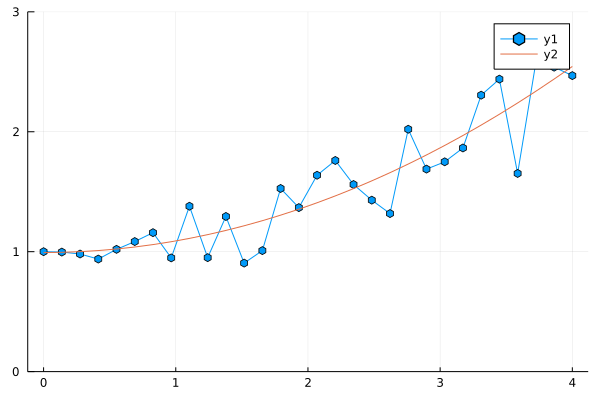

In [98]:
cost(p) = sum(abs2, mymodel.(xdata, p[1], p[2]) .- ydata)
fit = optimize(cost, [1., 1.], NelderMead())

a, b = fit.minimizer

plot(xdata, ydata, marker=:hex)
plot!(xdata, mymodel.(xdata, a, b))
ylims!(0, 3)

MLE estimate of parameters

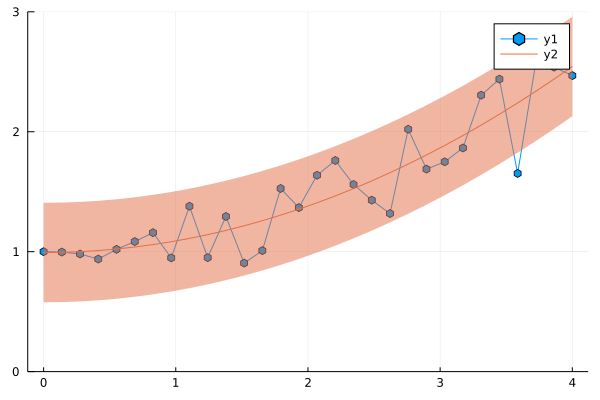

In [108]:
@model function model(x, y)
    s ~ truncated(Normal(0, 1), 0, Inf)
    a ~ Normal(1, s)
    b ~ Normal(1, s)

    for i in eachindex(y)
        y[i] ~ Normal(mymodel.(x[i], a, b), s)
    end
#     y ~ MvNormal(mymodel(x, fit.minimizer), diagm(σ))
end

mle_estimate = optimize(model(xdata, ydata), MLE(), BFGS(), Optim.Options(iterations=10^5))

a, b, s = mle_estimate.values[:a], mle_estimate.values[:b], mle_estimate.values[:s]
lower = -1.96s*fill(1, size(xdata))
upper = -1.96s*fill(1, size(xdata))

plot(xdata, ydata, marker=:hex)
plot!(xdata, mymodel.(xdata, a, b), ribbon=[lower, upper])
ylims!(0, 3)

MLE estimate of parameters and errors

[0.2170390324867127, 0.08333970180907227, 1.1014888499782054, 3.1555469911875447, 0.1362663912554393, 0.482709167817087, 1.019780438851682, 0.8925802172056926, 0.04972737791808218, 2.058981193064838e-15, 17.399603918511698, 0.16002086678561986, 0.947917207155761, 0.3231733919732767, 0.6341629352906367, 7.00496413473299, 0.809787923275974, 0.8976802800487295, 0.26627410767685633, 0.3329753950038761, 0.005843793881639412, 0.287253418006173, 0.8111609895058086, 0.09635879244224727, 2.255951691470926, 5.542934071674232, 0.26629030528479264, 0.8658426186147286, 1.7114929338467055, 0.8849683395667375, 0.9746674179535699, 0.14540202339014344, 1.0335384193103052]

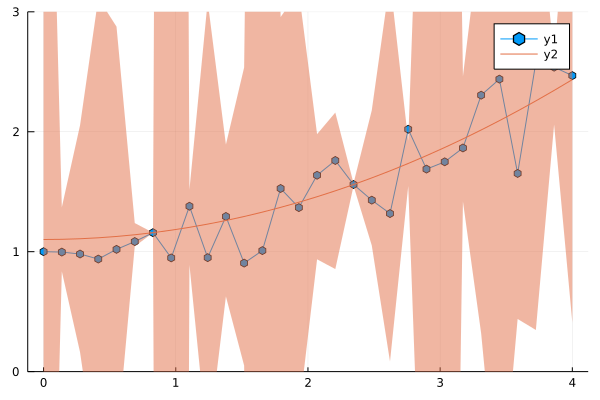

In [110]:
@model function model(x, y)
    s ~ truncated(Normal(0, 1), 0, Inf)
    a ~ Normal(1, s)
    b ~ Normal(1, s)
    σ ~ MvLogNormal(fill(0., size(ydata)), s)

    for i in eachindex(y)
        y[i] ~ Normal(mymodel.(x[i], a, b), σ[i])
    end
#     y ~ MvNormal(mymodel(x, fit.minimizer), diagm(σ))
end

mle_estimate = optimize(model(xdata, ydata), MLE(), NelderMead(), Optim.Options(iterations=10^5))

a, b = mle_estimate.values[:a], mle_estimate.values[:b]
lower = -1.96mle_estimate.values[4:end].array
upper = 1.96mle_estimate.values[4:end].array
print(mle_estimate)

plot(xdata, ydata, marker=:hex)
plot!(xdata, mymodel.(xdata, a, b), ribbon=[lower, upper])
ylims!(0, 3)

MAP estimation of parameters and error

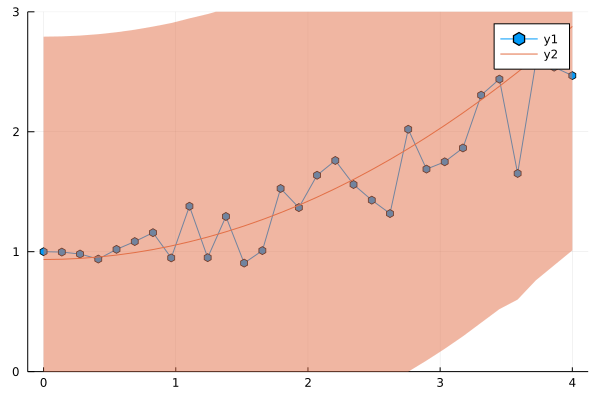

In [111]:
@model function model(x, y)
    s ~ truncated(Normal(0, 1), 0, Inf)
    a ~ truncated(Normal(1, s), 0, Inf)
    b ~ truncated(Normal(1, s), 0, Inf)
    σ ~ MvLogNormal(fill(0., size(ydata)), s)
    
    p = [a, b]

    for i in eachindex(y)
        y[i] ~ Normal(mymodel.(x[i], a, b), σ[i])
    end
#     y ~ MvNormal(mymodel(x, fit.minimizer), diagm(σ))
end

map_estimate = optimize(model(xdata, ydata), MAP(), AcceleratedGradientDescent())

a, b = map_estimate.values[:a], map_estimate.values[:b]
lower = -1.96map_estimate.values[4:end].array
upper = 1.96map_estimate.values[4:end].array

plot(xdata, ydata, marker=:hex)
plot!(xdata, mymodel.(xdata, a, b), ribbon=[lower, upper])
ylims!(0, 3)

MCMC simulation to estimate parameters and confidence interval

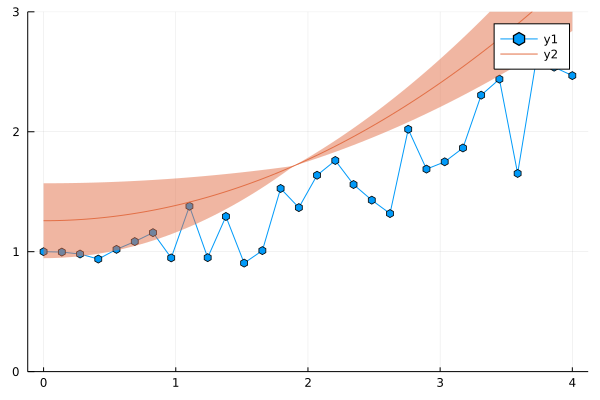

In [115]:
Random.seed!(15);

@model function model(x, y)
    s ~ truncated(Normal(0, 1), 0, Inf)
    a ~ Normal(1, s)
    b ~ Normal(1, s)

    for i in eachindex(y)
        y[i] ~ Normal(mymodel(x[i], a, b), s)
    end
end
# Run sampler, collect results.
chain = sample(model(xdata, ydata), SMC(), 1000)

df = DataFrame(chain)
xx = range(0, 4, length = 100)
yy = [mymodel.(x, df.a, df.b) for x in xx]
mm = [mean(y) for y in yy]
qq = [quantile(y, [0.025, 0.975]) for y in yy]
lower = [q[1] - m for (q, m) in zip(qq, mm)]
upper = [q[2] - m for (q, m) in zip(qq, mm)]

plot(xdata, ydata, marker=:hex)
plot!(xx, mymodel.(xx, mean(df.a), mean(df.b)), ribbon=[lower, upper])
ylims!(0, 3)

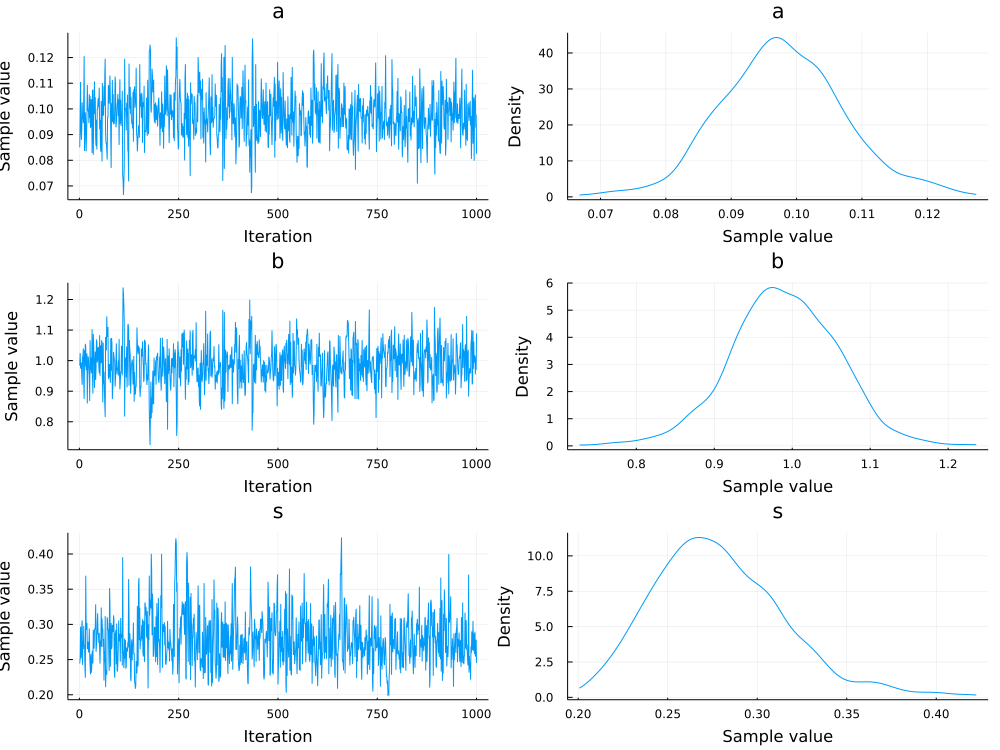

In [114]:
plot(chain)

In [ ]:
Random.seed!(15);

@model function model(x, y)
    s ~ truncated(Normal(0, 1), 0, Inf)
    a ~ Normal(1, s)
    b ~ Normal(1, s)

    for i in eachindex(y)
        y[i] ~ Normal(mymodel(x[i], a, b), s)
    end
end
mle_estimate = optimize(model(xdata, ydata), MLE(), BFGS(), Optim.Options(iterations=10^5))

# Run sampler, collect results.
chain = sample(model(xdata, ydata), NUTS(), 1000)

df = DataFrame(chain)
xx = range(0, 4, length = 100)
yy = [mymodel.(x, df.a, df.b) for x in xx]
mm = [mean(y) for y in yy]
qq = [quantile(y, [0.025, 0.975]) for y in yy]
lower = [q[1] - m for (q, m) in zip(qq, mm)]
upper = [q[2] - m for (q, m) in zip(qq, mm)]

plot(xdata, ydata, marker=:hex)
plot!(xx, mymodel.(xx, mean(df.a), mean(df.b)), ribbon=[lower, upper])
ylims!(0, 3)

In [113]:
# Note that loading Optim explicitly is required for mode estimation to function,
# as Turing does not load the opimization suite unless Optim is loaded as well.
using Turing
using Optim

@model function gdemo(x)
    s ~ InverseGamma(2, 3)

    for i in eachindex(x)
        x[i] ~ Normal(m, sqrt(s))
    end
end

gdemo (generic function with 2 methods)

In [120]:
# Create some data to pass to the model.
data = [1.5, 2.0, 2.1]

# Instantiate the gdemo model with our data.
model = gdemo(data)

DynamicPPL.Model{var"#29#30", (:x,), (), (), Tuple{Vector{Float64}}, Tuple{}}(:gdemo, var"#29#30"(), (x = [1.5, 2.0, 2.1],), NamedTuple())

In [129]:
#  Run sampler, collect results.
chain = sample(model, HMC(1.5, 2), 1000)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/shigoto/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/shigoto/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/shigoto/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/shigoto/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (tru

Chains MCMC chain (1000×11×1 Array{Float64, 3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
parameters        = m, s
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, n_steps, nom_step_size, step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat 
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64 

           m    1.9270    0.9075     0.0287    0.2902    2.7136    1.7245
           s    2.9270    2.0968     0.0663    0.6518    4.5221    1.2247

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           m    0.0120    1.2787    2.3790    2.7879    2.8427
           s    0.5185    0.7172    2.3305    5.4201    5.7924


In [130]:
mean(chain[:s])

2.9270008479894276

In [205]:
# Generate a MLE estim`ate.
mle_estimate = optimize(model, MLE(), NelderMead())

ModeResult with maximized lp of -0.24
2-element Named Vector{Float64}
A  │ 
───┼──────────
:s │ 0.0688849
:m │   1.86667

In [207]:
@model function gdemo(ttdata, vvdata)
    s ~ InverseGamma(2, 3)
    m ~ Normal(0, sqrt(s))

    for i in eachindex(vvdata)
        vvdata[i] ~ Normal(0, sqrt(s))
    end
end

gdemo (generic function with 2 methods)

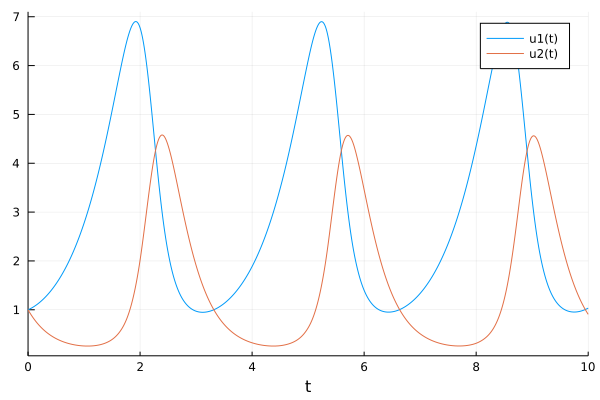

In [16]:
plot(sol)

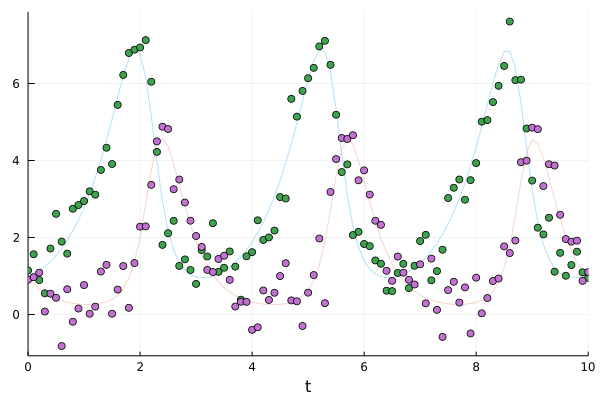

In [51]:
sol1 = solve(prob1,Tsit5(),saveat=0.1)
odedata = Array(sol1) + 0.5 * randn(size(Array(sol1)))
plot(sol1, alpha = 0.3, legend = false); scatter!(sol1.t, odedata')

In [52]:
Turing.setadbackend(:forwarddiff)

@model function fitlv(data, prob1)
    σ ~ InverseGamma(2, 3) # ~ is the tilde character
    α ~ truncated(Normal(1.5,0.5),0.5,2.5)
    β ~ truncated(Normal(1.2,0.5),0,2)
    γ ~ truncated(Normal(3.3,0.5),1,4)
    δ ~ truncated(Normal(1.1,0.5),0,2)

    p = [α,β,γ,δ]
    prob = remake(prob1, p=p)
    predicted = solve(prob,Tsit5(),saveat=0.1)

    for i = 1:length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ)
    end
end

model = fitlv(odedata, prob1)

# This next command runs 3 independent chains without using multithreading. 
chain = mapreduce(c -> sample(model, NUTS(.65),1000), chainscat, 1:3)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/shigoto/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/shigoto/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /home/shigoto/.julia/packages/Turing/QYtu8/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/shigoto/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:08
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/shigoto/.julia/packages/Turing/QYtu8/src/inference/hm

Chains MCMC chain (1000×17×3 Array{Float64, 3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3
Samples per chain = 1000
parameters        = α, β, γ, δ, σ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat 
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64 

           α    1.6904    0.3183     0.0058    0.0576    6.3007    4.8004
           β    1.2675    0.4116     0.0075    0.0753    6.1638    6.5006
           γ    3.2310    0.2751     0.0050    0.0427    8.4406    1.9057
           δ    1.2530    0.3370     0.0062    0.0607    6.3636    4.3795
           σ    1.0192    0.7298     0.0133    0.1349    6.0558   12.0585

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     9

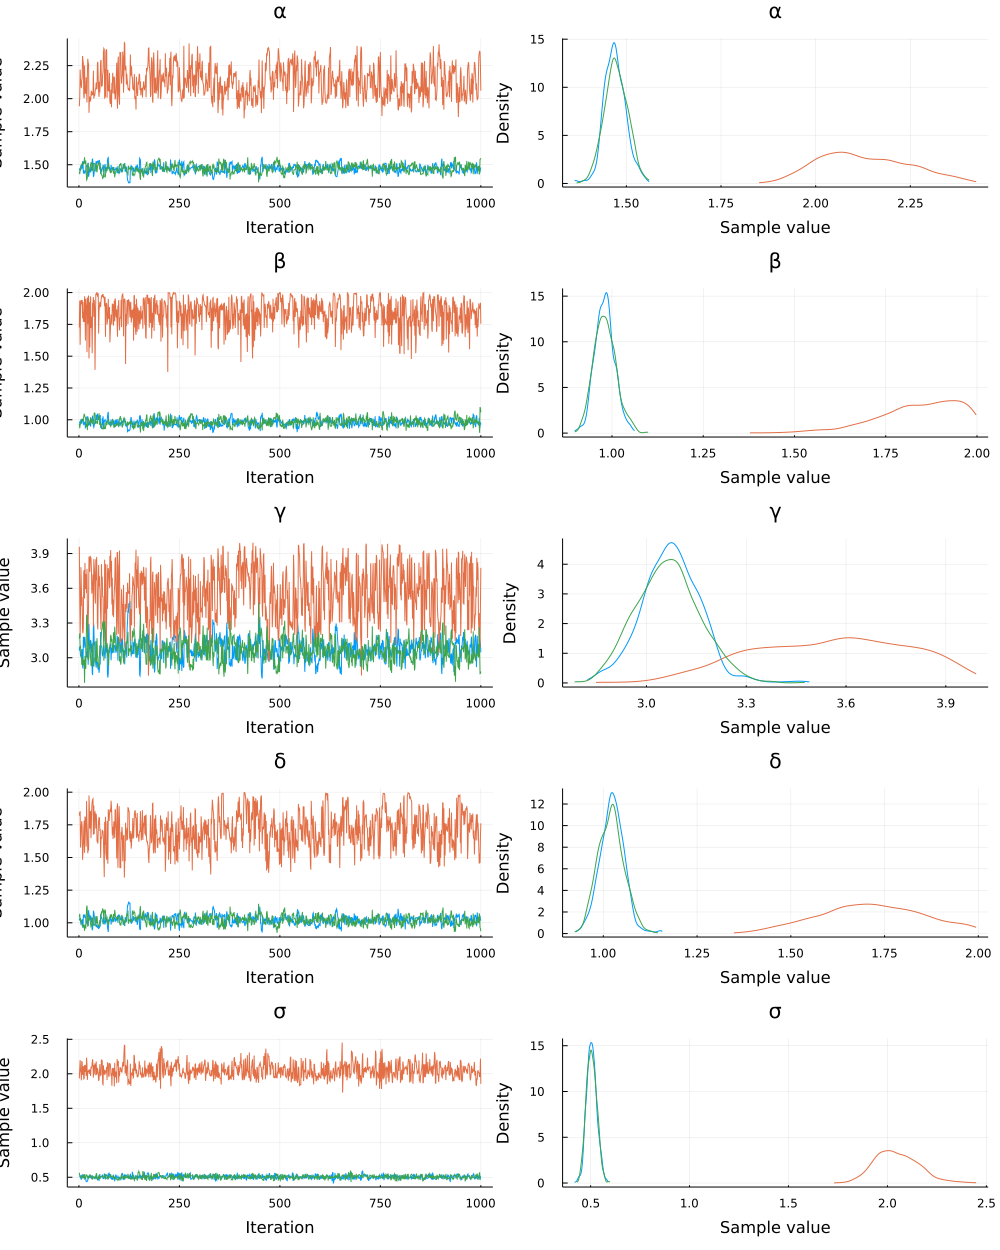

In [53]:
plot(chain)

In [93]:
?chainscat

search: chainscat



```
chainscat(c::AbstractChains...)
```

Concatenate multiple chains.

By default, the chains are concatenated along the third dimension by calling `cat(c...; dims=3)`.
